In [ ]:
# Mount Google Drive and extract zip files with subfolder handling
from google.colab import drive
import zipfile
import os
import shutil

drive.mount('/content/drive')

drive_folder = '/content/drive/MyDrive/present_sbox'
local_data_dir = '/content/data'

os.makedirs(local_data_dir, exist_ok=True)

bucket_mapping = {
    'present_normal_images.zip': 'original',
    'present_3to1_cipher.zip': 'sbox_3to1',
    'present_3to2_cipher.zip': 'sbox_3to2',
    'present_3to5_images.zip': 'sbox_3to5'
}


def extract_and_handle_subfolder(zip_path, extract_path, has_subfolder=False):
    # Extract the zip file
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

    # Handle subfolder if needed
    if has_subfolder:
        subfolder_path = os.path.join(extract_path, 'encrypted_images')
        if os.path.exists(subfolder_path):
            # Move all files from subfolder to main directory
            for file_name in os.listdir(subfolder_path):
                src = os.path.join(subfolder_path, file_name)
                dst = os.path.join(extract_path, file_name)
                shutil.move(src, dst)

            # Remove the now-empty subfolder
            os.rmdir(subfolder_path)

# Extract each zip file
for zip_file, bucket_name in bucket_mapping.items():
    zip_path = os.path.join(drive_folder, zip_file)
    extract_path = os.path.join(local_data_dir, bucket_name)

    # Create bucket directory
    os.makedirs(extract_path, exist_ok=True)

    print(f"Extracting {zip_file} to {bucket_name}...")

    # Determine if this bucket has subfolder
    has_subfolder = bucket_name in ['sbox_3to1', 'sbox_3to2']
    extract_and_handle_subfolder(zip_path, extract_path, has_subfolder)

    # Count extracted PNG files
    file_count = len([f for f in os.listdir(extract_path) if f.lower().endswith('.png')])
    print(f"✓ Extracted {file_count} images to {bucket_name}")

print("\nAll buckets extracted successfully!")

# Verify directory structure
print("\nDirectory structure:")
for bucket in bucket_mapping.values():
    bucket_path = os.path.join(local_data_dir, bucket)
    if os.path.exists(bucket_path):
        file_count = len([f for f in os.listdir(bucket_path) if f.lower().endswith('.png')])
        print(f"{bucket}: {file_count} images")


Mounted at /content/drive
Extracting present_normal_images.zip to original...
✓ Extracted 50000 images to original
Extracting present_3to1_cipher.zip to sbox_3to1...
✓ Extracted 50000 images to sbox_3to1
Extracting present_3to2_cipher.zip to sbox_3to2...
✓ Extracted 50000 images to sbox_3to2
Extracting present_3to5_images.zip to sbox_3to5...
✓ Extracted 50000 images to sbox_3to5

All buckets extracted successfully!

Directory structure:
original: 50000 images
sbox_3to1: 50000 images
sbox_3to2: 50000 images
sbox_3to5: 50000 images


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")



Using device: cuda


Loading original...
✓ Loaded 50000 images from original
Loading sbox_3to1...
✓ Loaded 50000 images from sbox_3to1
Loading sbox_3to2...
✓ Loaded 50000 images from sbox_3to2
Loading sbox_3to5...
✓ Loaded 50000 images from sbox_3to5

Total dataset: 200000 images, Shape: (200000, 32, 32, 3)
Class distribution: [50000 50000 50000 50000]


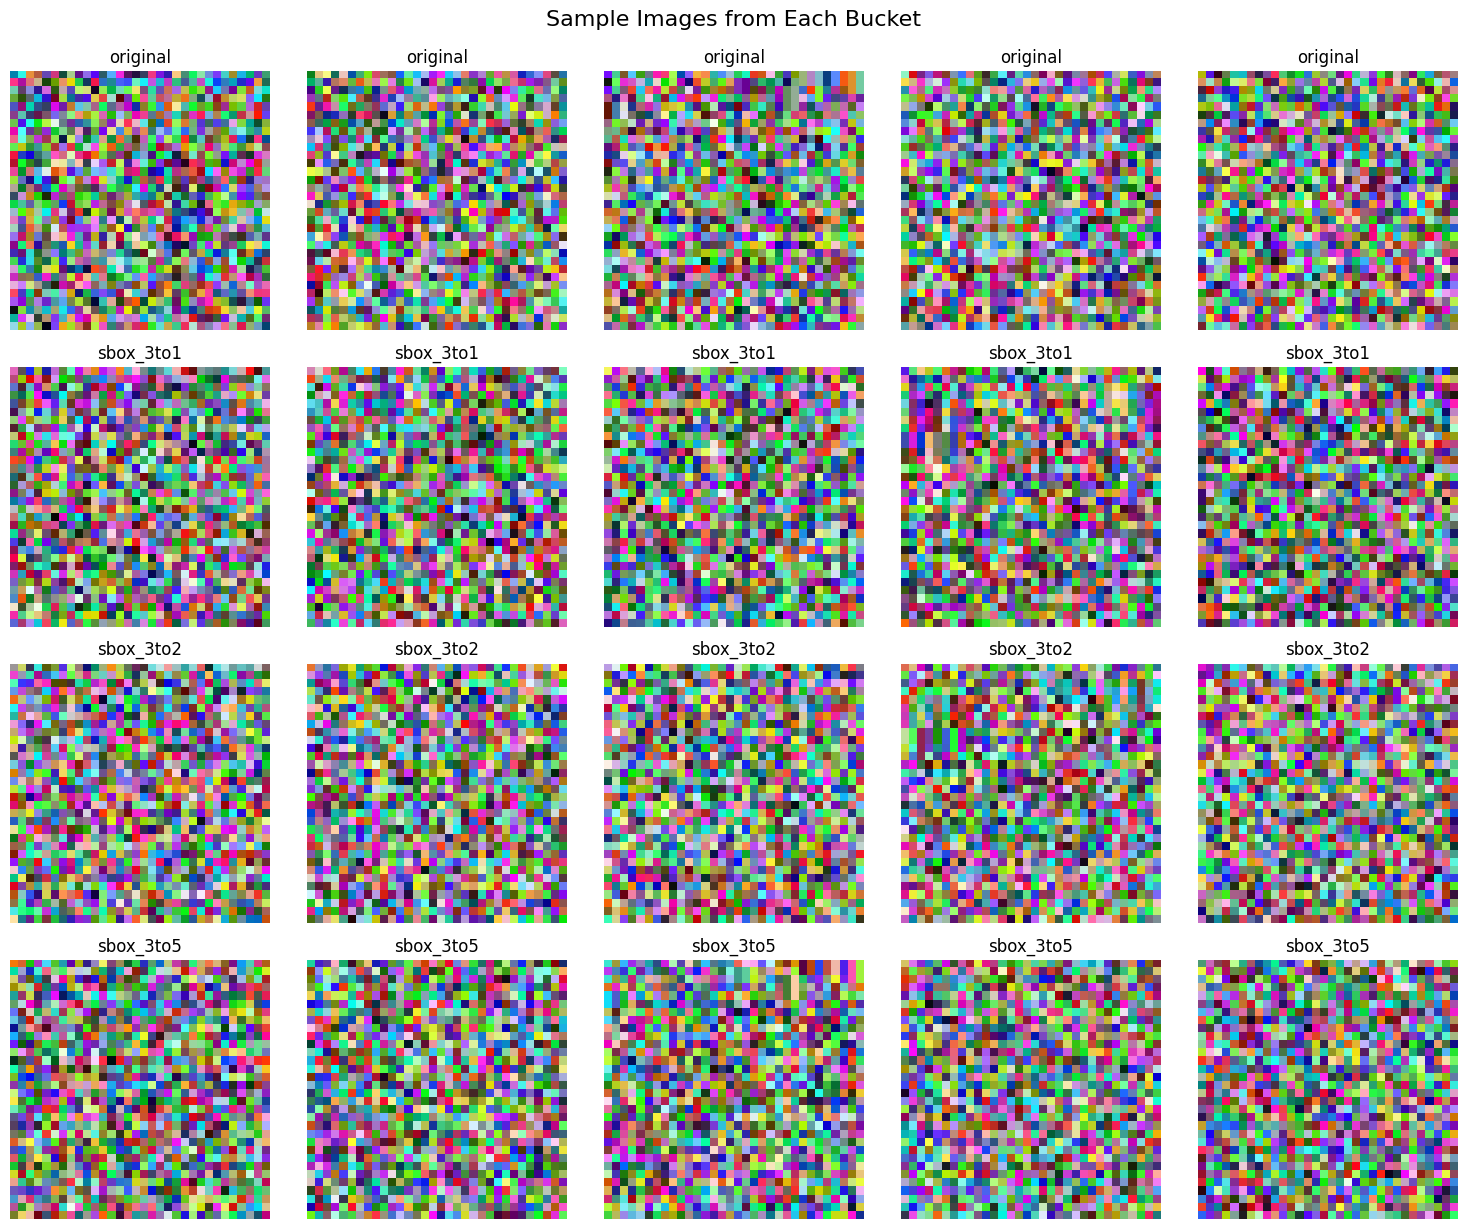

In [ ]:
# Load images from extracted folders
# Data loading for 4 buckets
def load_bucket_images(bucket_path, label):
    """Load images from a bucket directory"""
    images = []
    labels = []

    # Handle potential subdirectories in extracted zip
    for root, dirs, files in os.walk(bucket_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(root, file)
                try:
                    img = Image.open(img_path).convert('RGB')
                    if img.size == (32, 32):  # Ensure CIFAR-10 size
                        images.append(np.array(img))
                        labels.append(label)
                except Exception as e:
                    print(f"Error loading {img_path}: {e}")

    return images, labels

# Load all 4 buckets
buckets = ['original', 'sbox_3to1', 'sbox_3to2', 'sbox_3to5']
all_images = []
all_labels = []

for i, bucket in enumerate(buckets):
    bucket_path = f'/content/data/{bucket}'
    print(f"Loading {bucket}...")
    images, labels = load_bucket_images(bucket_path, i)
    all_images.extend(images)
    all_labels.extend(labels)
    print(f"✓ Loaded {len(images)} images from {bucket}")

# Convert to arrays
X = np.array(all_images)
y = np.array(all_labels)

print(f"\nTotal dataset: {len(X)} images, Shape: {X.shape}")
print(f"Class distribution: {np.bincount(y)}")

# Visualize samples from each bucket
def plot_bucket_samples(images, labels, bucket_names):
    fig, axes = plt.subplots(4, 5, figsize=(15, 12))

    for bucket_idx in range(4):
        bucket_images = [images[i] for i in range(len(images)) if labels[i] == bucket_idx]

        for img_idx in range(5):
            if img_idx < len(bucket_images):
                axes[bucket_idx, img_idx].imshow(bucket_images[img_idx])
                axes[bucket_idx, img_idx].set_title(f"{bucket_names[bucket_idx]}")
            axes[bucket_idx, img_idx].axis('off')

    plt.tight_layout()
    plt.suptitle("Sample Images from Each Bucket", fontsize=16, y=1.02)
    plt.show()

plot_bucket_samples(all_images, all_labels, buckets)


In [ ]:
# Define PyTorch Dataset and DataLoader
class EncryptedCIFAR10(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create datasets
train_dataset = EncryptedCIFAR10(X_train, y_train, transform=transform)
val_dataset = EncryptedCIFAR10(X_val, y_val, transform=transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128)

print(f"Training set: {len(train_dataset)} images")
print(f"Validation set: {len(val_dataset)} images")


Training set: 160000 images
Validation set: 40000 images


In [ ]:
# Define AlexNet model
class AlexNet(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 192, 3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(192, 384, 3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [ ]:
# Define MobileNetV2 model
import torch.nn.functional as F

class Block(nn.Module):
    '''expand + depthwise + pointwise'''
    def __init__(self, in_planes, out_planes, expansion, stride):
        super(Block, self).__init__()
        self.stride = stride
        planes = expansion * in_planes

        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, groups=planes, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn3 = nn.BatchNorm2d(out_planes)

        self.shortcut = nn.Sequential()
        if stride == 1 and in_planes != out_planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(out_planes),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out = out + self.shortcut(x) if self.stride==1 else out
        return out

class MobileNetV2(nn.Module):
    # (expansion, out_planes, num_blocks, stride)
    cfg = [
        (1,  16, 1, 1),
        (6,  24, 2, 1),
        (6,  32, 3, 2),
        (6,  64, 4, 2),
        (6,  96, 3, 1),
        (6, 160, 3, 2),
        (6, 320, 1, 1),
    ]

    def __init__(self, num_classes=4):
        super(MobileNetV2, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32)
        self.conv2 = nn.Conv2d(320, 1280, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(1280)
        self.linear = nn.Linear(1280, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for expansion, out_planes, num_blocks, stride in self.cfg:
            strides = [stride] + [1]*(num_blocks-1)
            for stride in strides:
                layers.append(Block(in_planes, out_planes, expansion, stride))
                in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.relu(self.bn2(self.conv2(out)))
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


In [ ]:
# Define training function with early stopping
import time

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_accuracy = 0.0
        self.early_stop = False

    def __call__(self, current_accuracy):
        if current_accuracy > self.best_accuracy + self.min_delta:
            self.best_accuracy = current_accuracy
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        return self.early_stop

def train_model(model, name, train_loader, val_loader, epochs=50, patience=5):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    criterion = nn.CrossEntropyLoss()
    early_stopping = EarlyStopping(patience=patience)

    train_losses, val_accs = [], []
    best_acc = 0.0
    best_model_wts = None

    start_time = time.time()

    for epoch in range(epochs):
        # Training
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        # Validation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc = 100 * correct / total
        val_accs.append(val_acc)

        # Update best model
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict().copy()

        # Early stopping check
        if early_stopping(val_acc):
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

        # Print progress
        print(f"{name} Epoch {epoch+1}/{epochs} | Loss: {epoch_loss:.4f} | Val Acc: {val_acc:.2f}% | Best Acc: {best_acc:.2f}%")

    # Load best model weights
    model.load_state_dict(best_model_wts)
    training_time = time.time() - start_time
    print(f"\nTraining completed in {training_time//60:.0f}m {training_time%60:.0f}s")
    print(f"Best validation accuracy: {best_acc:.2f}%")

    return model, train_losses, val_accs

In [ ]:
print("TRAINING PHASE")

alexnet = AlexNet(num_classes=4)
print("\nTraining AlexNet with early stopping...")
alexnet_trained, alex_losses, alex_accs = train_model(
    alexnet, "AlexNet", train_loader, val_loader,
    epochs=50, patience=5
)


TRAINING PHASE

Training AlexNet with early stopping...
AlexNet Epoch 1/50 | Loss: 0.1472 | Val Acc: 85.62% | Best Acc: 85.62%
AlexNet Epoch 2/50 | Loss: 0.0372 | Val Acc: 91.20% | Best Acc: 91.20%
AlexNet Epoch 3/50 | Loss: 0.0281 | Val Acc: 72.34% | Best Acc: 91.20%
AlexNet Epoch 4/50 | Loss: 0.0246 | Val Acc: 93.31% | Best Acc: 93.31%
AlexNet Epoch 5/50 | Loss: 0.0227 | Val Acc: 98.80% | Best Acc: 98.80%
AlexNet Epoch 6/50 | Loss: 0.0182 | Val Acc: 97.21% | Best Acc: 98.80%
AlexNet Epoch 7/50 | Loss: 0.0178 | Val Acc: 97.69% | Best Acc: 98.80%
AlexNet Epoch 8/50 | Loss: 0.0167 | Val Acc: 99.15% | Best Acc: 99.15%
AlexNet Epoch 9/50 | Loss: 0.0146 | Val Acc: 98.62% | Best Acc: 99.15%
AlexNet Epoch 10/50 | Loss: 0.0144 | Val Acc: 99.36% | Best Acc: 99.36%
AlexNet Epoch 11/50 | Loss: 0.0119 | Val Acc: 99.00% | Best Acc: 99.36%
AlexNet Epoch 12/50 | Loss: 0.0119 | Val Acc: 98.56% | Best Acc: 99.36%
AlexNet Epoch 13/50 | Loss: 0.0118 | Val Acc: 99.44% | Best Acc: 99.44%
AlexNet Epoch 14/

In [ ]:
print("\nTraining MobileNetV2 with early stopping...")

mobilenet = MobileNetV2(num_classes=4)
mobilenet_trained, mobile_losses, mobile_accs = train_model(
    mobilenet, "MobileNetV2", train_loader, val_loader,
    epochs=50, patience=5
)



Training MobileNetV2 with early stopping...
MobileNetV2 Epoch 1/50 | Loss: 0.1244 | Val Acc: 97.88% | Best Acc: 97.88%
MobileNetV2 Epoch 2/50 | Loss: 0.0379 | Val Acc: 98.81% | Best Acc: 98.81%
MobileNetV2 Epoch 3/50 | Loss: 0.0251 | Val Acc: 99.36% | Best Acc: 99.36%
MobileNetV2 Epoch 4/50 | Loss: 0.0191 | Val Acc: 99.39% | Best Acc: 99.39%
MobileNetV2 Epoch 5/50 | Loss: 0.0164 | Val Acc: 99.45% | Best Acc: 99.45%
MobileNetV2 Epoch 6/50 | Loss: 0.0126 | Val Acc: 99.56% | Best Acc: 99.56%
MobileNetV2 Epoch 7/50 | Loss: 0.0111 | Val Acc: 99.67% | Best Acc: 99.67%
MobileNetV2 Epoch 8/50 | Loss: 0.0088 | Val Acc: 99.61% | Best Acc: 99.67%
MobileNetV2 Epoch 9/50 | Loss: 0.0081 | Val Acc: 99.76% | Best Acc: 99.76%
MobileNetV2 Epoch 10/50 | Loss: 0.0062 | Val Acc: 99.61% | Best Acc: 99.76%
MobileNetV2 Epoch 11/50 | Loss: 0.0060 | Val Acc: 99.67% | Best Acc: 99.76%
MobileNetV2 Epoch 12/50 | Loss: 0.0054 | Val Acc: 99.74% | Best Acc: 99.76%
MobileNetV2 Epoch 13/50 | Loss: 0.0049 | Val Acc: 99


EVALUATION RESULTS

AlexNet Results:

Overall Accuracy: 97.86%

Per-class Accuracy:
  original: 92.72% (9272/10000)
  sbox_3to1: 99.98% (9998/10000)
  sbox_3to2: 98.85% (9885/10000)
  sbox_3to5: 99.90% (9990/10000)

 MobileNetV2 Results:

Overall Accuracy: 99.96%

Per-class Accuracy:
  original: 99.90% (9990/10000)
  sbox_3to1: 99.99% (9999/10000)
  sbox_3to2: 99.96% (9996/10000)
  sbox_3to5: 99.98% (9998/10000)


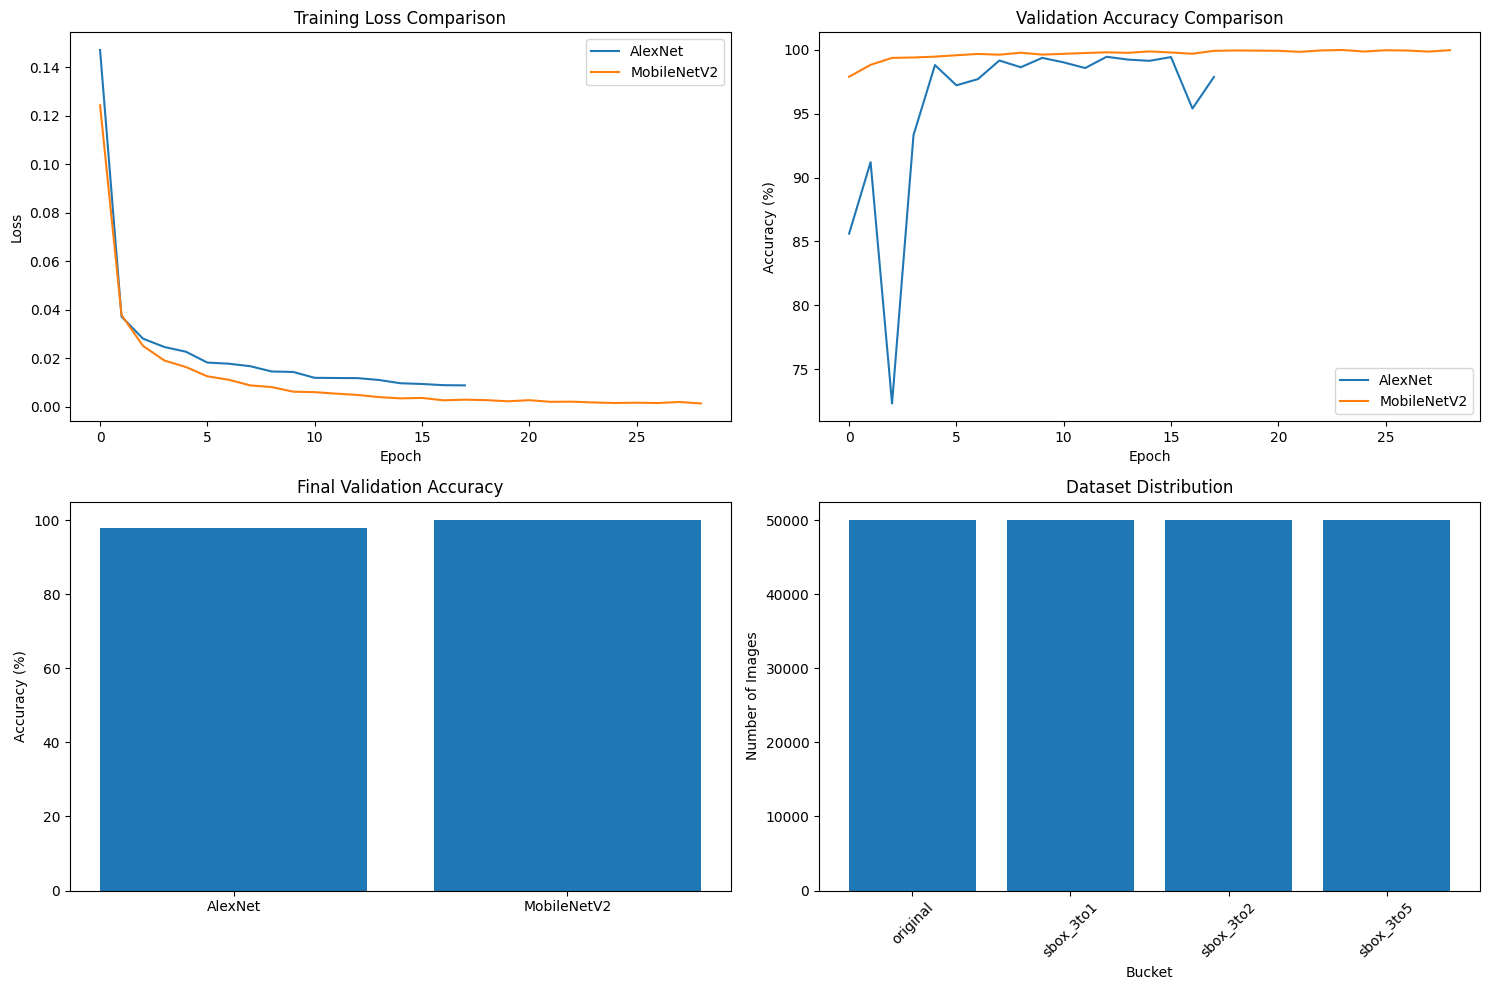


Training and evaluation completed!


In [ ]:
# Evaluation function and results
def evaluate_model(model, data_loader, class_names):
    model.eval()
    correct, total = 0, 0
    class_correct = [0] * len(class_names)
    class_total = [0] * len(class_names)

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Per-class accuracy
            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += (predicted[i] == label).item()
                class_total[label] += 1

    overall_acc = 100 * correct / total

    print(f"\nOverall Accuracy: {overall_acc:.2f}%")
    print("\nPer-class Accuracy:")
    for i, class_name in enumerate(class_names):
        if class_total[i] > 0:
            acc = 100 * class_correct[i] / class_total[i]
            print(f"  {class_name}: {acc:.2f}% ({class_correct[i]}/{class_total[i]})")

    return overall_acc

print("\n" + "="*50)
print("EVALUATION RESULTS")
print("="*50)

print("\nAlexNet Results:")
alex_acc = evaluate_model(alexnet_trained, val_loader, buckets)

print("\n MobileNetV2 Results:")
mobile_acc = evaluate_model(mobilenet_trained, val_loader, buckets)

# Plot training history
plt.figure(figsize=(15, 10))

# Loss comparison
plt.subplot(2, 2, 1)
plt.plot(alex_losses, label='AlexNet')
plt.plot(mobile_losses, label='MobileNetV2')
plt.title('Training Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy comparison
plt.subplot(2, 2, 2)
plt.plot(alex_accs, label='AlexNet')
plt.plot(mobile_accs, label='MobileNetV2')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

# Model performance
plt.subplot(2, 2, 3)
plt.bar(['AlexNet', 'MobileNetV2'], [alex_acc, mobile_acc])
plt.title('Final Validation Accuracy')
plt.ylabel('Accuracy (%)')

# Dataset distribution
plt.subplot(2, 2, 4)
plt.bar(buckets, np.bincount(y))
plt.title('Dataset Distribution')
plt.xlabel('Bucket')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print("\nTraining and evaluation completed!")

In [ ]:
# Visualization of Predictions

def visualize_predictions(model, dataloader, class_names, num_images=15):
    model.eval()
    images, labels = next(iter(dataloader))
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(images[:num_images])
        _, preds = torch.max(outputs, 1)

    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    for i, ax in enumerate(axes.flat):
        if i < num_images:

            img = images[i].cpu().permute(1, 2, 0).numpy()
            img = img * 0.5 + 0.5

            ax.imshow(img)
            ax.set_title(f"Pred: {class_names[preds[i]]}\nTrue: {class_names[labels[i]]}",
                         color=("green" if preds[i] == labels[i] else "red"))
            ax.axis('off')
    plt.tight_layout()
    plt.show()

bucket_names = ['original', 'sbox_3to1', 'sbox_3to2', 'sbox_3to5']



AlexNet Predictions:


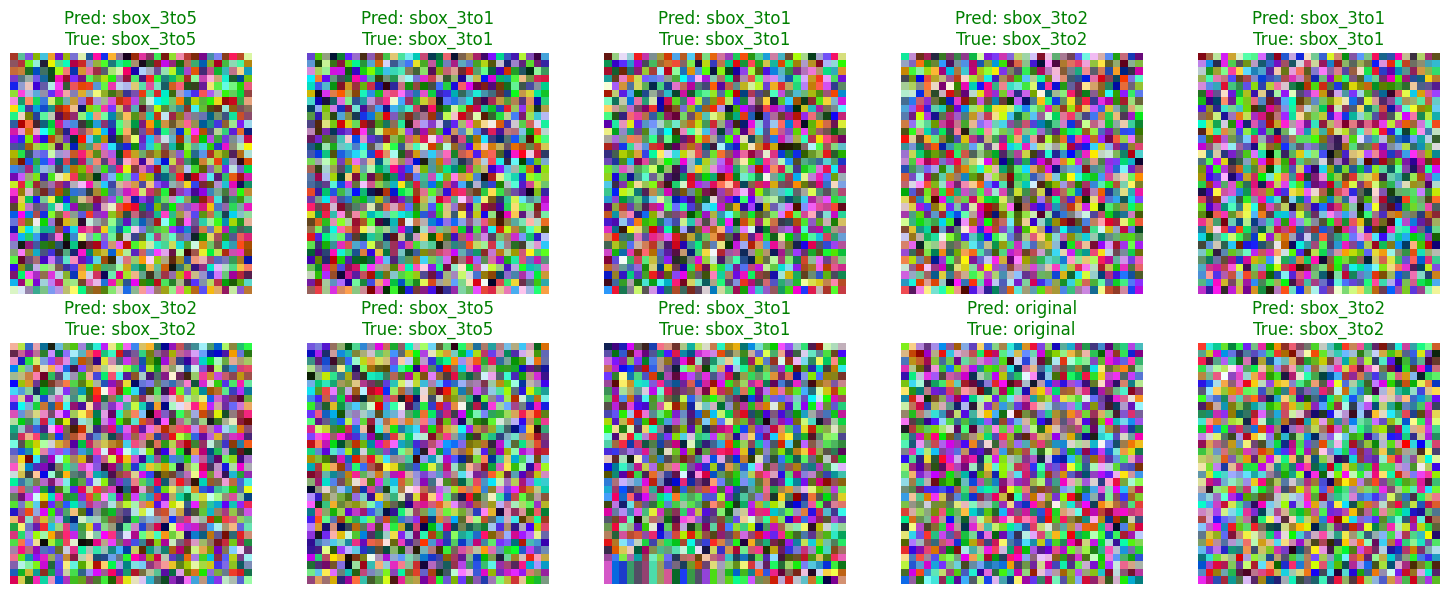


MobileNetV2 Predictions:


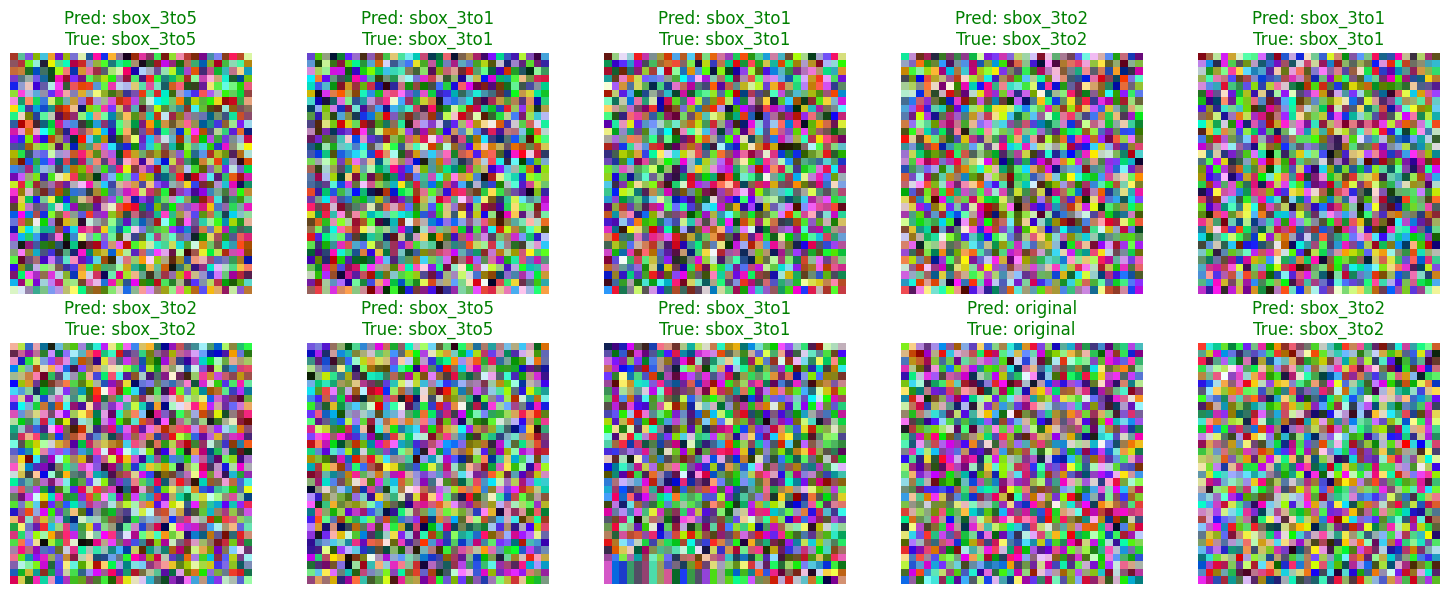

In [ ]:
# For AlexNet
print("\nAlexNet Predictions:")
visualize_predictions(alexnet_trained, val_loader, bucket_names)

# For MobileNetV2
print("\nMobileNetV2 Predictions:")
visualize_predictions(mobilenet_trained, val_loader, bucket_names)

In [ ]:
from google.colab import drive
import torch

save_folder = '/content/drive/MyDrive/present_sbox'

# Paths to save the models
alexnet_save_path = f'{save_folder}/alexnet_trained.pth'
mobilenet_save_path = f'{save_folder}/mobilenet_trained.pth'

# Save the models
torch.save(alexnet_trained.state_dict(), alexnet_save_path)
torch.save(mobilenet_trained.state_dict(), mobilenet_save_path)

print('Models saved successfully to Google Drive folder:')
print(save_folder)


Models saved successfully to Google Drive folder:
/content/drive/MyDrive/present_sbox
